In [ ]:
##Term 2 work
#Saving data, improving functions
#Trying out other sigkernel package

In [1]:
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm

In [3]:
#Observations
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observations = xr.open_zarr(obs_path)
#observationsshort = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')) #Same time?
#observationsvals = observationsshort.values
#observationslong = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-03-01')) #Same time?
#observationsvalslong = observationslong.values
#6 Hour increments

In [54]:
observations

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [8]:
#IFS ENS
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
forecast1 = xr.open_zarr(forecast_path)
#12 Hour increments, pred 6 Hours #61

In [9]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [10]:
#IFSHRES
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
forecast3 = xr.open_zarr(forecast_path)
forecast3
#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [11]:
#ERA 5 forecast
forecast4 = xr.open_zarr('gs://weatherbench2/datasets/era5-forecasts/2020-64x32_equiangular_conservative.zarr')
forecast4
#12 Hour increments, pred 6 Hours #31

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 31,
                              longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int32 500 700 850
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 00:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    vertical_velocity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [12]:
#Keisler GNN
forecast5 = xr.open_zarr('gs://weatherbench2/datasets/keisler/2020-64x32_equiangular_conservative.zarr')
forecast5

#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:               (level: 3, time: 732, prediction_timedelta: 41,
                           longitude: 64, latitude: 32)
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 500 700 850
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-31T12:...
Data variables:
    geopotential          (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    specific_humidity     (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    temperature           (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    u_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    v_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    wind_speed            (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>

In [12]:
#forecast1vals = forecast1['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast2vals = forecast2['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast3vals = forecast3['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast4vals = forecast4['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast5vals = forecast5['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast3valslong = forecast3['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-03-01')).values

In [24]:
#np.save('forecast1vals.npy', forecast1vals)
#np.save('forecast2vals.npy', forecast2vals)
#np.save('forecast3vals.npy', forecast3vals)
#np.save('forecast4vals.npy', forecast4vals)
#np.save('forecast5vals.npy', forecast5vals)
#np.save('forecast3valslong.npy', forecast3valslong)
#np.save('observationsvals.npy', observationsvals)
#np.save('observationsvalslong.npy', observationsvalslong)


In [112]:
#pkscalefors
#scaleall50
#pkscaleobs
#pkscaleall50
#check out
forecast1vals.shape

#Issue here
forecast1vals[:,:,0:65,:,:].shape #61

(64, 50, 61, 64, 32)

In [81]:
forecast3

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [127]:
from datetime import datetime, timedelta

def timecutting(obsxarray,forsxarray, days, predtimedelta):
    startdate = datetime(2020,1,1)
    newdate = startdate + timedelta(days=days)
    obsnewdate = newdate + timedelta(hours = (predtimedelta-1)*6)

    #print(newdate.strftime('%Y-%m-%d %H:%M:%S'))
    #print(obsnewdate.strftime('%Y-%m-%d %H:%M:%S'))
    


    return obsxarray['geopotential'].sel(level = 500, time = slice(startdate, obsnewdate)), forsxarray['geopotential'].sel(level = 500, time = slice(startdate, newdate)), 



In [173]:
testobs, testfor = timecutting(observations,forecast3,15,41) #Forecast 3 predtimedetla is 41

print(testobs.shape)
print(testfor.shape)

testobs1 = testobs.values
testfor1 = testfor.values

array([[[49846.934, 50196.53 , 50391.094, ..., 49346.07 , 48721.14 ,
         48363.79 ],
        [49836.32 , 50231.81 , 50376.41 , ..., 49362.816, 48740.695,
         48399.574],
        [49839.477, 50292.52 , 50394.6  , ..., 49312.086, 48726.99 ,
         48424.836],
        ...,
        [49888.54 , 50265.293, 50398.473, ..., 48852.195, 48387.645,
         48139.22 ],
        [49876.535, 50229.004, 50432.53 , ..., 49068.562, 48550.92 ,
         48234.207],
        [49861.684, 50200.12 , 50412.035, ..., 49238.684, 48659.176,
         48309.336]],

       [[49742.703, 50126.03 , 50244.926, ..., 49348.305, 48718.184,
         48521.867],
        [49742.4  , 50149.953, 50246.25 , ..., 49409.645, 48759.758,
         48551.38 ],
        [49744.56 , 50198.223, 50266.094, ..., 49378.285, 48758.688,
         48564.734],
        ...,
        [49730.91 , 50140.51 , 50237.   , ..., 48773.426, 48364.414,
         48335.   ],
        [49738.797, 50129.133, 50264.2  , ..., 49025.637, 48526.04 ,
   

In [ ]:
#Getting actual values

In [5]:
obslong = np.load('observationsvalslong.npy')
forlong = np.load('forecast3valslong.npy')

In [40]:
print(obslong.shape)
print(forlong.shape)

(244, 64, 32)
(122, 41, 64, 32)


In [53]:
obslong.shape #(244,64,32) Time long lat
forlong.shape #(122,41,64,32) Time, predict lag, long lat

(122, 41, 64, 32)

In [143]:
count = 0
for i in range(2,42):
    print(i)
    count+=1

count

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


40

In [126]:
forlong[5,0:0,0,0].shape

(0,)

In [139]:
forlong[0,0:41,0,0]

array([49871.094, 49767.363, 49779.812, 49801.477, 49804.723, 49773.035,
       49775.6  , 49802.36 , 49848.4  , 49879.152, 49954.45 , 50033.984,
       50103.64 , 50131.023, 50139.297, 50066.105, 49970.742, 49855.117,
       49782.86 , 49735.406, 49770.96 , 49846.6  , 49965.496, 50156.812,
       50417.625, 50651.96 , 50857.15 , 50977.562, 51009.83 , 50937.586,
       50845.543, 50747.82 , 50637.94 , 50525.9  , 50466.637, 50433.938,
       50440.484, 50441.062, 50483.758, 50502.508, 50511.57 ],
      dtype=float32)

In [6]:
def scalebyobs(observations,forecasts):
    mean = np.mean(observations)
    std = np.std(observations)
    scaledobs = (observations - mean)/std
    scaledfors = (forecasts - mean)/std

    return scaledobs, scaledfors

In [135]:
#Given forecast of time T with predlag, and observations of time T + predlag
#Average each path of length k across all t.
#zero is either 1 or 0 
def pk(observations,forecasts,long,lat,zero):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        lead = forecasts.shape[1]
        #print(time,lead)
        
        pkarray = np.zeros((time,lead,3))
        #print(pkarray.shape)

        #Across all t, across all lags
        for t in range(time):
            #print(t)
            for lag in range(2,lead+1):
                #print(lag)
                fors = forecasts[t,0:lag,j,l]
                obs = observations[2*t+zero:2*t+zero+lag,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)

                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                K_XX = signature_kernel.compute_Gram(X, X, sym=False, max_batch=100)
                K_yy = signature_kernel.compute_Gram(y, y, sym=False, max_batch=100)

                pkarray[t,lag-1,0] = K_Xy
                pkarray[t,lag-1,1] = K_XX
                pkarray[t,lag-1,2] = K_yy
        
        pkarray = np.mean(pkarray, axis=0)
        distance = pkarray[:,1]+pkarray[:,2]-2*pkarray[:,0]
        score = pkarray[:,1] - 2*pkarray[:,0]

    
        return(pkarray,distance,score)

In [194]:
testobs, testfor = timecutting(observations,forecast3,30,41) #Forecast 3 predtimedetla is 41

print(testobs.shape)
print(testfor.shape)

testobs1 = testobs.values
testfor1 = testfor.values

2020-01-31 00:00:00
2020-02-10 00:00:00
(161, 64, 32)
(61, 41, 64, 32)


In [13]:
#forecast 3 41 timelag
testobs1, testfor1 = timecutting(observations,forecast3,30,41)
testobs1 = testobs1.values
testfor1 = testfor1.values
scaleobs1, scalefors1 = scalebyobs(testobs1,testfor1)
newpk1, newdistance1,score1 = pk(scaleobs1,scalefors1,61,29,0)

In [142]:
def workflow(observations, forecasts, days, lag, long, lat,zero):
    ob, fo = timecutting(observations,forecasts,days,lag+zero)
    ob = ob.values
    fo = fo[:,0:lag,:,:].values
    ob, fo = scalebyobs(ob,fo)
    newpk, distance,score = pk(ob,fo,long,lat,zero)
    return (newpk, distance,score)


In [ ]:
# #forecast 2 61 timelag
# #Testing shorter then longer to see
# newpk2, newdistance2,score2 = workflow(observations, forecast2, days = 30, lag = 41, long = 61, lat = 29, zero = 0)

In [211]:
newpk2, newdistance2,score2 = workflow(observations, forecast2, days = 30, lag = 61, long = 61, lat = 29, zero = 0)

In [208]:
newpk3, newdistance3,score3 = workflow(observations, forecast3, days = 30, lag = 41, long = 61, lat = 29, zero = 0)

In [210]:
newpk4, newdistance4,score4 = workflow(observations, forecast4, days = 30, lag = 31, long = 61, lat = 29, zero = 0)

In [209]:
newpk5, newdistance5,score5 = workflow(observations, forecast5, days = 30, lag = 41, long = 61, lat = 29, zero = 0)

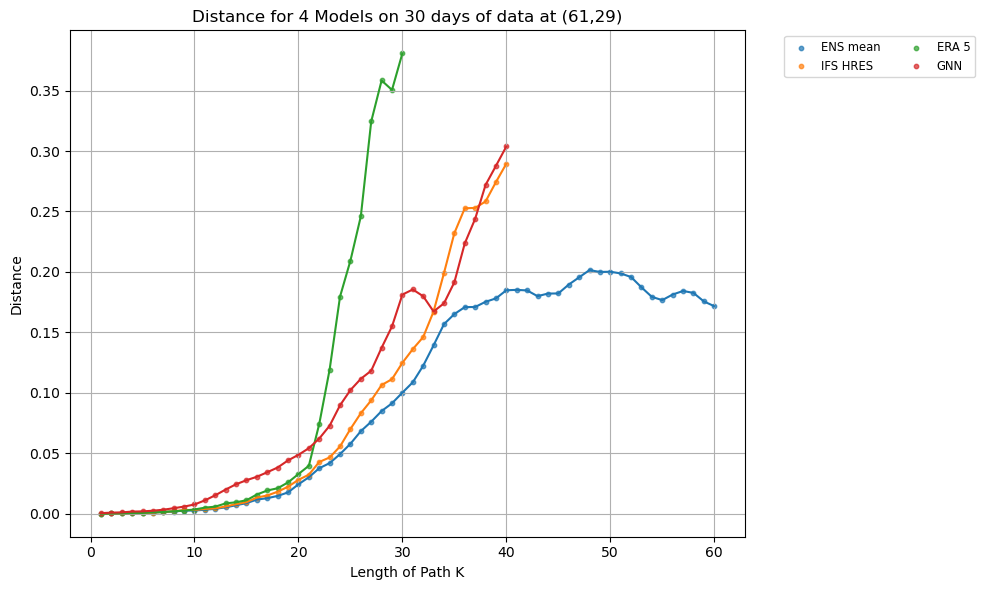

In [171]:
modellist = [newdistance2,newdistance3,newdistance4,newdistance5]
Models = ["ENS mean", "IFS HRES", "ERA 5", "GNN"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Distance for 4 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

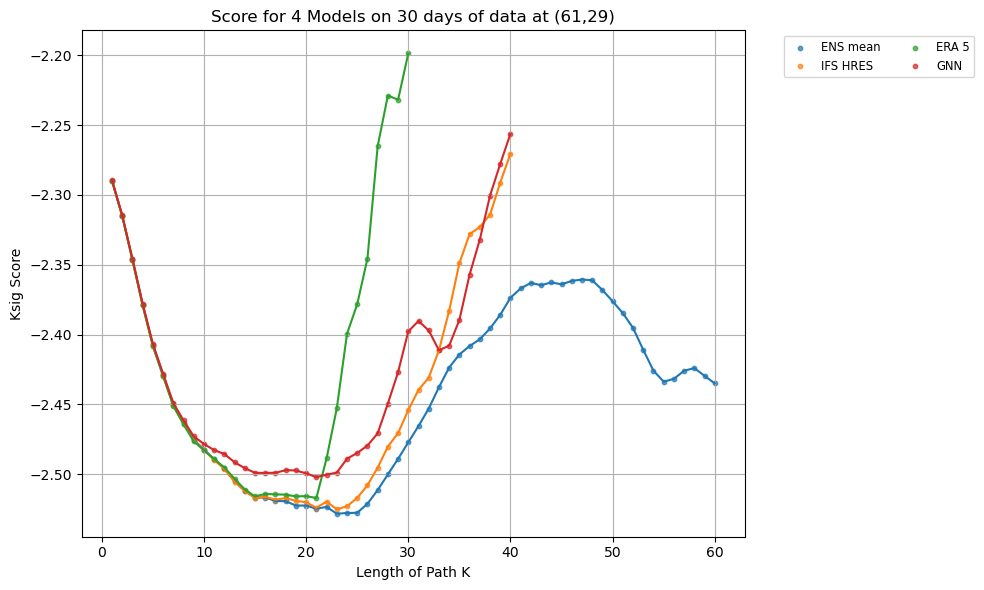

In [174]:
modellist = [score2,score3,score4,score5]
Models = ["ENS mean", "IFS HRES", "ERA 5", "GNN"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Score for 4 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Ksig Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    

In [74]:
#Could save with specified long,lat, but helpful for next step

def ensworkflowfirst(observations, forecasts, days, lag):
    ob, fo = timecutting(observations,forecasts,days,lag)
    ob = ob.values
    fo = fo[:,:,0:lag,:,:].values
    ob, fo = scalebyobs(ob,fo)
    np.save('cutobsdays' + str(days) + 'lag' + str(lag) + '.npy', ob)
    np.save('forecast1valsdays' + str(days) + 'lag' + str(lag) + '.npy', fo)

In [77]:
def ensworkflowsecond(observations, forecasts, long, lat):
    ob = observations
    fo = forecasts
    modelnum = fo.shape[1]
    lag = fo.shape[2]
    pkarary = np.zeros((modelnum, lag, 3))
    distancearray = np.zeros((modelnum, lag))
    scorearray = np.zeros((modelnum, lag))
    for f in range(modelnum):
        print(f)
        fof = fo[:,f,:,:,:]
        newpk, distance,score = pk(ob,fof,long,lat)
        pkarary[f,:,:] = newpk
        distancearray[f,:] = distance
        scorearray[f,:] = score
    return (pkarary, distancearray, scorearray)

In [54]:
ensworkflowfirst(observations, forecast1, days = 30, lag =61)

calcvalues


In [56]:
obtest = np.load('cutobsdays30lag61.npy')
fortest = np.load('forecast1valsdays30lag61.npy')

In [69]:
fortest.shape

(61, 50, 61, 64, 32)

In [78]:
pkarary1, distancearray1, scorearray1 = ensworkflowsecond(obtest, fortest, long =61, lat=29)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [79]:
np.save('pkarrayforecast1_30_61_61_29.npy', pkarary1)
np.save('distancearrayforecast1_30_61_61_29.py', distancearray1)
np.save('scorearrayforecast1_30_61_61_29.py', scorearray1)

In [80]:
pkarary2, distancearray2, scorearray2 = ensworkflowsecond(obtest, fortest, long =32, lat=16)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [81]:
np.save('pkarrayforecast1_30_61_32_16.npy', pkarary2)
np.save('distancearrayforecast1_30_61_32_16.py', distancearray2)
np.save('scorearrayforecast1_30_61_32_16.py', scorearray2)

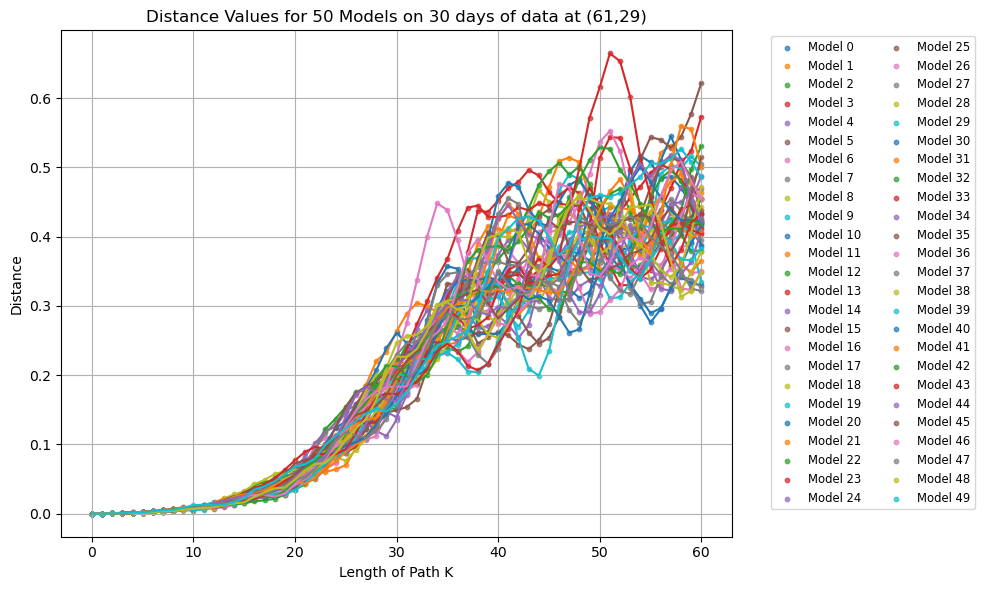

In [103]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for f in range(50):
    plt.scatter(
            np.arange(distancearray1[f,:].shape[0]),  # Time steps (x-axis)
            distancearray1[f,:],     # Model predictions (y-axis)
            label=f'Model ' +str(f),
            alpha=0.7,                # Adjust transparency
            s=10)
    plt.plot(np.arange(distancearray1[f,:].shape[0]), distancearray1[f,:], alpha=1)                # Size of the dots
# Customize the plot
plt.title('Distance Values for 50 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

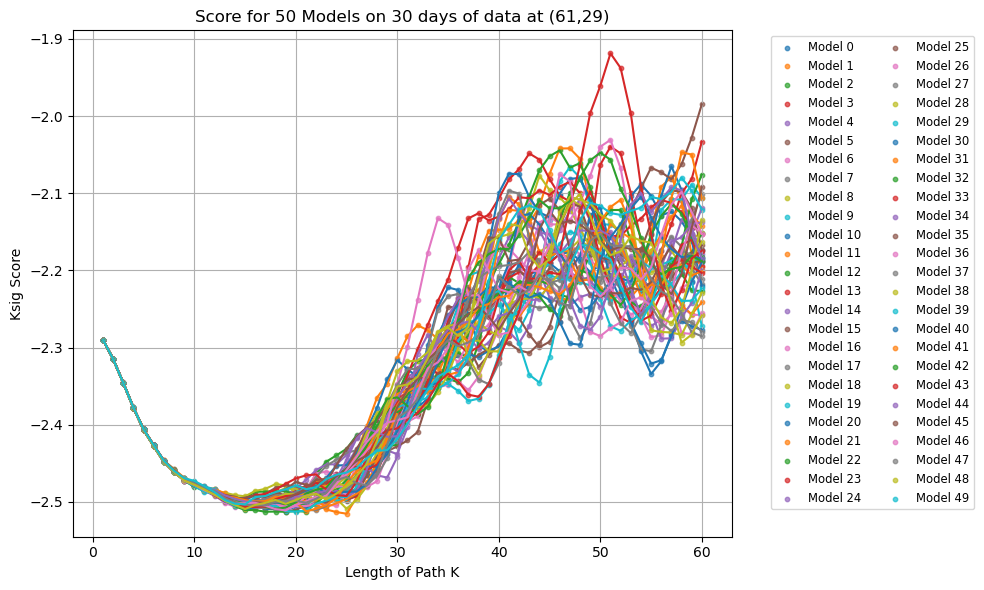

In [104]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for f in range(50):
    plt.scatter(
            np.arange(scorearray1[f,1:].shape[0])+1,  # Time steps (x-axis)
            scorearray1[f,1:],     # Model predictions (y-axis)
            label=f'Model ' +str(f),
            alpha=0.7,                # Adjust transparency
            s=10)
    plt.plot(np.arange(scorearray1[f,1:].shape[0])+1, scorearray1[f,1:], alpha=1)                # Size of the dots
# Customize the plot
plt.title('Score for 50 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Ksig Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

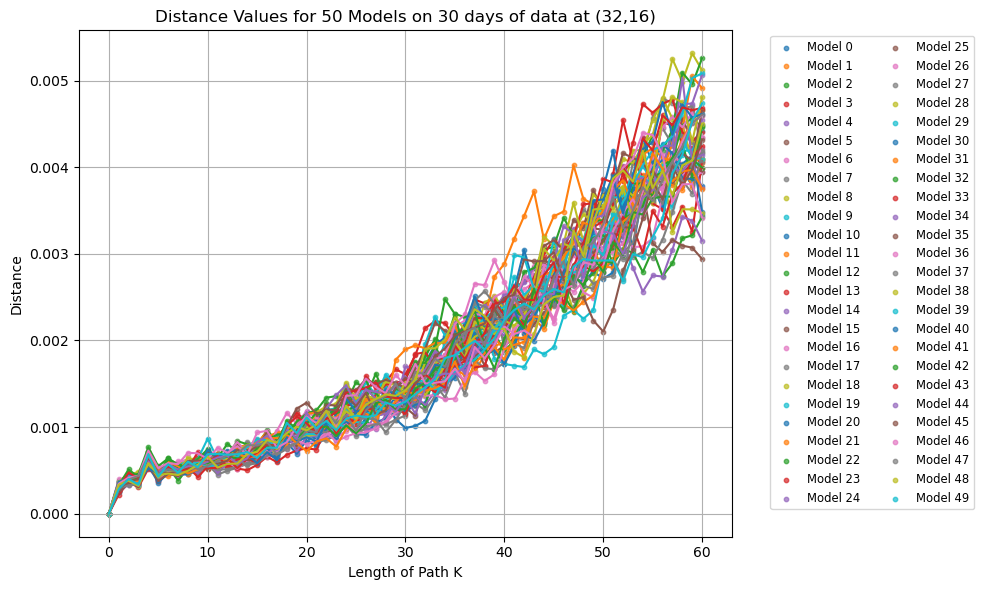

In [105]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for f in range(50):
    plt.scatter(
            np.arange(distancearray2[f,:].shape[0]),  # Time steps (x-axis)
            distancearray2[f,:],     # Model predictions (y-axis)
            label=f'Model ' +str(f),
            alpha=0.7,                # Adjust transparency
            s=10)
    plt.plot(np.arange(distancearray2[f,:].shape[0]), distancearray2[f,:], alpha=1)                # Size of the dots
# Customize the plot
plt.title('Distance Values for 50 Models on 30 days of data at (32,16)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

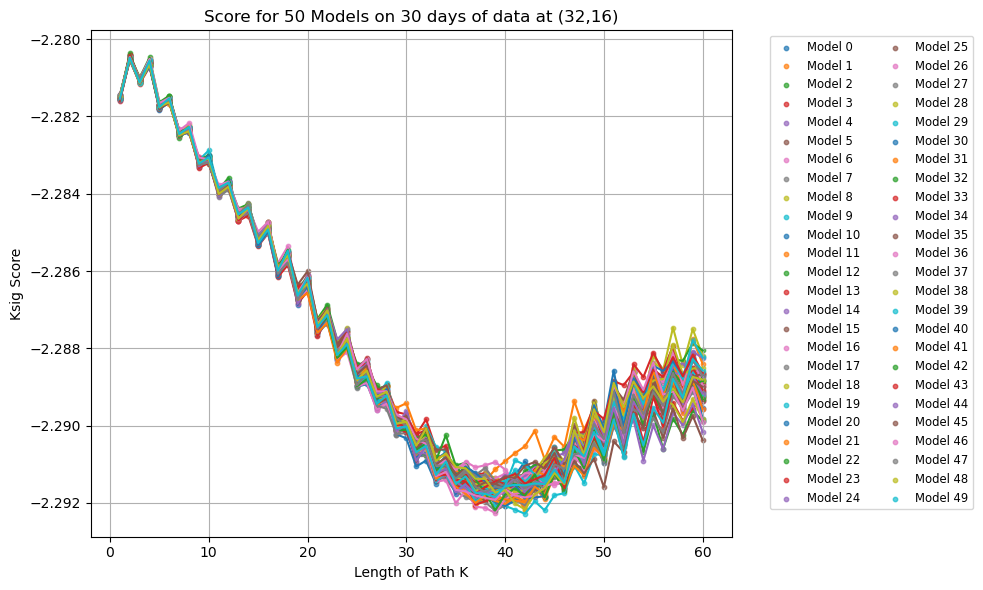

In [120]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
for f in range(50):
    plt.scatter(
            np.arange(scorearray2[f,1:].shape[0])+1,  # Time steps (x-axis)
            scorearray2[f,1:],     # Model predictions (y-axis)
            label=f'Model ' +str(f),
            alpha=0.7,                # Adjust transparency
            s=10)
    plt.plot(np.arange(scorearray2[f,1:].shape[0])+1, scorearray2[f,1:], alpha=1)                # Size of the dots
# Customize the plot
plt.title('Score for 50 Models on 30 days of data at (32,16)')
plt.xlabel('Length of Path K')
plt.ylabel('Ksig Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [109]:
distest = distancearray1[:,1:]


In [ ]:
distest

In [110]:
ranked_matrix = np.zeros_like(distest, dtype=int)

# Rank the values at each length (column-wise ranking)
for col in range(distest.shape[1]):
    # Get the sorted indices for the column
    sorted_indices = np.argsort(distest[:, col])
    # Assign ranks (1 for the lowest, 50 for the highest)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(sorted_indices) + 1)
    # Store the ranks in the ranked matrix
    ranked_matrix[:, col] = ranks

In [111]:
ranked_matrix

array([[38, 28, 12, ..., 36, 32, 30],
       [24, 48, 48, ..., 41, 26, 18],
       [36,  6,  8, ..., 25, 28, 37],
       ...,
       [47, 36, 40, ...,  7,  3,  1],
       [37, 14, 23, ...,  1,  1,  5],
       [15, 27, 14, ..., 48, 46, 42]])

In [112]:
scoretest = scorearray1[:,1:]

In [115]:
ranked_matrix1 = np.zeros_like(scoretest, dtype=int)

# Rank the values at each length (column-wise ranking)
for col in range(scoretest.shape[1]):
    # Get the sorted indices for the column
    sorted_indices = np.argsort(scoretest[:, col])
    # Assign ranks (1 for the lowest, 50 for the highest)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(sorted_indices) + 1)
    # Store the ranks in the ranked matrix
    ranked_matrix1[:, col] = ranks

In [116]:
ranked_matrix1

array([[38, 28, 12, ..., 36, 32, 30],
       [24, 48, 48, ..., 41, 26, 18],
       [36,  6,  8, ..., 25, 28, 37],
       ...,
       [47, 36, 40, ...,  7,  3,  1],
       [37, 14, 23, ...,  1,  1,  5],
       [15, 27, 14, ..., 48, 46, 42]])

In [118]:
np.sum(ranked_matrix == ranked_matrix1)

3000

In [ ]:
#Score and Distance have same ordering

In [121]:
forecast6 = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')
forecast6
#12 Hour increments, pred 6 Hours #40, no time = 0? Useable, just don't compute for time =0?
#When finding MSE at all lags could just not find for that specific lag
#When comparing paths,  

<xarray.Dataset>
Dimensions:                  (time: 3652, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2018-01-01 ... 2022-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [122]:
#Pangu Weather operational
forecast7 = xr.open_zarr('gs://weatherbench2/datasets/pangu_hres_init/2020_0012_64x32_equiangular_conservative.zarr')
forecast7
#12 Hour increments, pred 6 Hours #40, no time = 0 for pangu

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [126]:
#Graphcast
forecast8 = xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')
forecast8

#12 Hour increments, pred 6 Hours #40, no 0 time

<xarray.Dataset>
Dimensions:                   (time: 886, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int64 1 2 3 5 7 ... 900 925 950 975 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2019-11-16 ... 2021-01-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>

In [124]:
#Graphcast operational
forecast9 = xr.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')
forecast9

#12 Hour increments, pred 6 Hours #40, no 0 time

<xarray.Dataset>
Dimensions:                   (time: 732, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2020-01-01 ... 2020-12-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [125]:
#Fuxi
forecast11 = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')
forecast11

#12 Hour increments, pred 6 Hours #60, no time 0

<xarray.Dataset>
Dimensions:                            (time: 702, prediction_timedelta: 60,
                                        longitude: 64, latitude: 32, level: 2)
Coordinates:
  * latitude                           (latitude) float64 -87.19 ... 87.19
  * level                              (level) int32 500 850
  * longitude                          (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta               (prediction_timedelta) timedelta64[ns] ...
  * time                               (time) datetime64[ns] 2020-01-01 ... 2...
Data variables:
    10m_u_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_wind_speed                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    2m_temperature                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    geopotential                       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    temperature                        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    total_precipitation_24hr_from_6hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    total_precipitation_6hr            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    u_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    v_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    wind_speed                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>

In [146]:
newpk6, newdistance6,score6 = workflow(observations, forecast6, days = 30, lag = 40, long = 61, lat = 29, zero = 1)

In [148]:
newpk7, newdistance7,score7 = workflow(observations, forecast7, days = 30, lag = 40, long = 61, lat = 29, zero = 1)

In [149]:
newpk8, newdistance8,score8 = workflow(observations, forecast8, days = 30, lag = 40, long = 61, lat = 29, zero = 1)

In [150]:
newpk9, newdistance9,score9 = workflow(observations, forecast9, days = 30, lag = 40, long = 61, lat = 29, zero = 1)

In [151]:
newpk11, newdistance11,score11 = workflow(observations, forecast11, days = 30, lag = 60, long = 61, lat = 29, zero = 1)

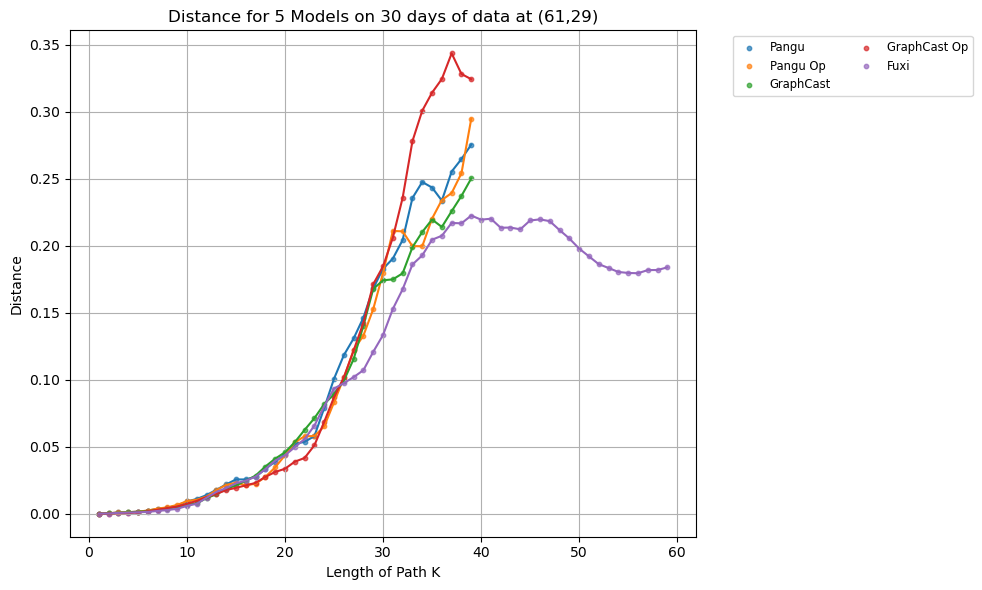

In [177]:
modellist = [newdistance6,newdistance7,newdistance8,newdistance9,newdistance11]
Models = ["Pangu", "Pangu Op", "GraphCast", "GraphCast Op", "Fuxi"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Distance for 5 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

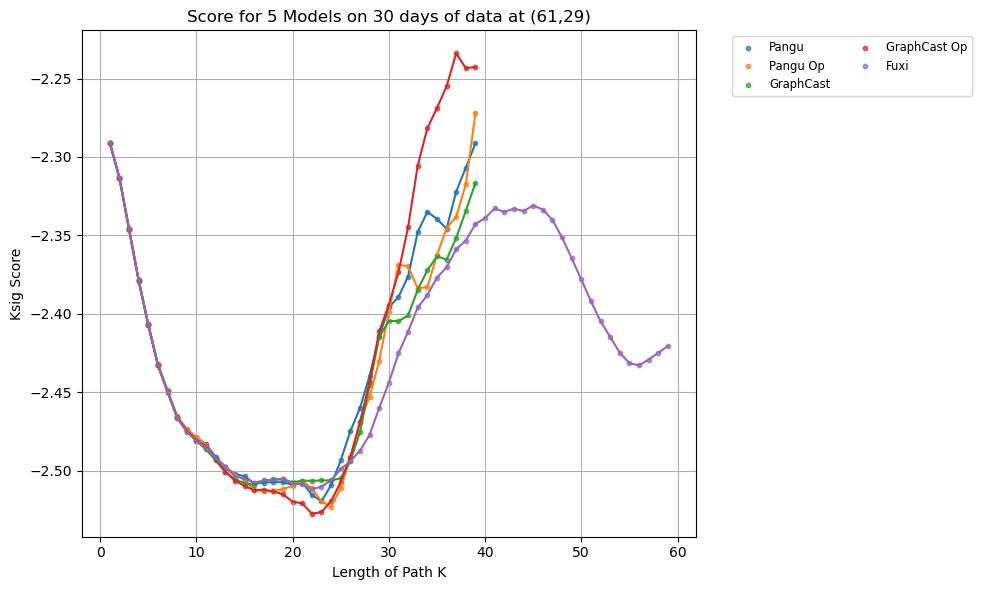

In [178]:
modellist = [score6,score7,score8,score9,score11]
Models = ["Pangu", "Pangu Op", "GraphCast", "GraphCast Op", "Fuxi"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10                      # Size of the dots
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Score for 5 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Ksig Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

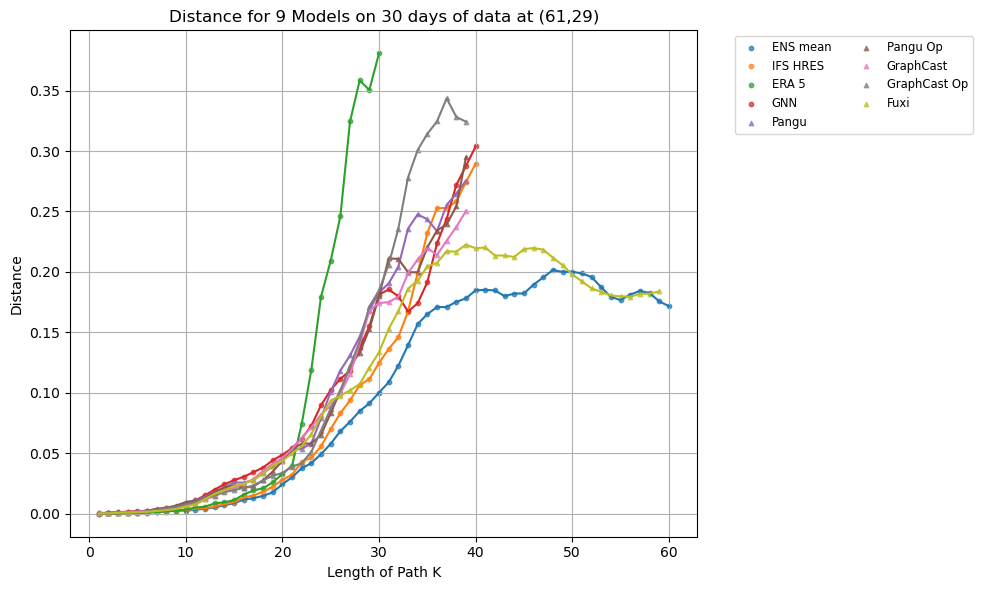

In [182]:
modellist = [newdistance2,newdistance3,newdistance4,newdistance5,newdistance6,newdistance7,newdistance8,newdistance9,newdistance11]
Models = ["ENS mean", "IFS HRES", "ERA 5", "GNN","Pangu", "Pangu Op", "GraphCast", "GraphCast Op", "Fuxi"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    marker_style = 'o' if model_index < Models.index("Pangu") else '^'
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10,                       # Size of the dots
        marker=marker_style  
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Distance for 9 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

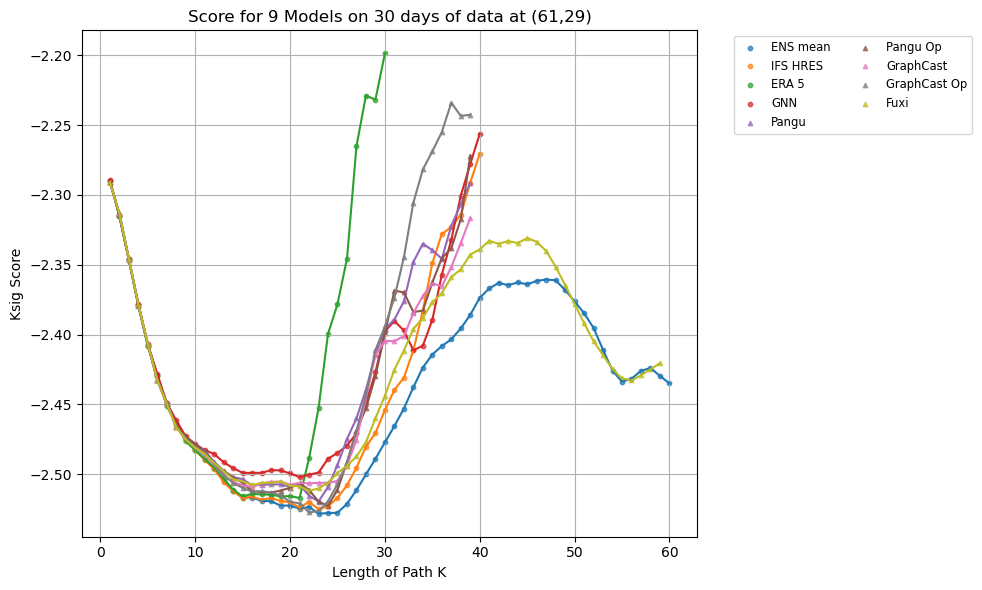

In [183]:
modellist = [score2,score3,score4,score5,score6,score7,score8,score9,score11]
Models = ["ENS mean", "IFS HRES", "ERA 5", "GNN","Pangu", "Pangu Op", "GraphCast", "GraphCast Op", "Fuxi"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    marker_style = 'o' if model_index < Models.index("Pangu") else '^'
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        modellist[model_index][1:],     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10,                       # Size of the dots
        marker=marker_style  
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, modellist[model_index][1:], alpha=1)

plt.title('Score for 9 Models on 30 days of data at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Ksig Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

In [ ]:
#Some models have initial time at 0, some don't
#How to compare
#Can compare on aligning length of Path K, models without initial time 0 will likely suffer as predicting events further out
#That could be okay, as we may want to penalize not having more current predictions?
#Or could align every model to not have initial time? 
#what does initial time even mean here?

#Usefulness as scoring rule: If there are no differences compared to MSE then not useful
#Currently there are differences, but this is only at one lat/long


In [225]:
# latitude = forecast1['latitude'][:].values
# delta = 2.8125
# theta_upper = latitude + delta
# theta_lower = latitude - delta

# # Calculate weights based on the provided formula
# weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
# weights /= weights.sum()
# weights *= 32

# weights

array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

In [199]:
# highres = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr')
# latitude = highres['latitude'][:].values
# delta = 0.125
# theta_upper = latitude + delta
# theta_lower = latitude - delta

# # Calculate weights based on the provided formula
# weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
# weights /= weights.sum()
# weights *= 32

# weights

array([0.        , 0.00030422, 0.0006094 , 0.00091362, 0.0012188 ,
       0.00152302, 0.00182724, 0.00213242, 0.00243664, 0.00273991,
       0.00304604, 0.00334931, 0.00365353, 0.00395776, 0.00426198,
       0.0045662 , 0.00487043, 0.0051737 , 0.00547696, 0.00578119,
       0.00608446, 0.00638868, 0.00669099, 0.00699426, 0.00729753,
       0.0076008 , 0.00790312, 0.00820543, 0.00850775, 0.00881102,
       0.00911238, 0.00941374, 0.00971606, 0.01001742, 0.01031973,
       0.01062014, 0.0109215 , 0.01122191, 0.01152232, 0.01182273,
       0.01212314, 0.01242259, 0.01272205, 0.01302245, 0.01332095,
       0.01361946, 0.01391891, 0.01421646, 0.01451591, 0.0148125 ,
       0.01511005, 0.0154076 , 0.01570419, 0.01600174, 0.01629738,
       0.01659397, 0.01688961, 0.0171843 , 0.01747994, 0.01777462,
       0.01806931, 0.01836304, 0.01865678, 0.01895051, 0.01924233,
       0.01953606, 0.01982789, 0.02011972, 0.02041154, 0.02070337,
       0.02099233, 0.02128415, 0.02157312, 0.02186304, 0.02215

(array([ 46.,  48.,  46.,  50.,  52.,  54.,  60.,  70.,  88., 207.]),
 array([0.        , 0.00698133, 0.01396266, 0.02094398, 0.02792531,
        0.03490664, 0.04188797, 0.0488693 , 0.05585063, 0.06283195,
        0.06981328]),
 <BarContainer object of 10 artists>)

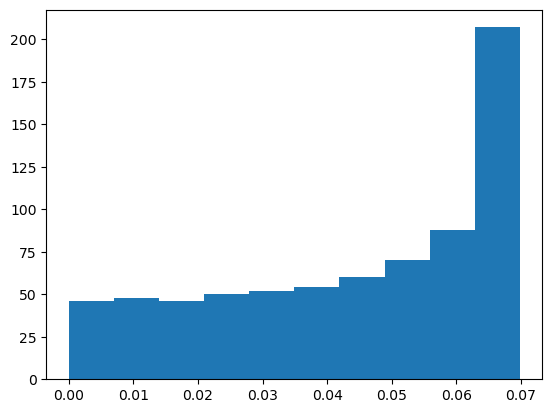

In [201]:
plt.hist(weights)

In [200]:
print(max(weights))
print(min(weights))

0.06981328
0.0


In [213]:
obtesting, fotesting = timecutting(observations,forecast4,30,31)

In [220]:
testing = fotesting[:,0:31,:,:].values

In [221]:
testing[0,0:2,:,0].shape

(2, 64)

In [233]:
np.ones((32,1,1,3))*weights[:,None,None,None]

array([[[[0.07704437, 0.07704437, 0.07704437]]],


       [[[0.23039114, 0.23039114, 0.23039114]]],


       [[[0.38151911, 0.38151911, 0.38151911]]],


       [[[0.52897285, 0.52897285, 0.52897285]]],


       [[[0.67133229, 0.67133229, 0.67133229]]],


       [[[0.80722643, 0.80722643, 0.80722643]]],


       [[[0.93534654, 0.93534654, 0.93534654]]],


       [[[1.05445875, 1.05445875, 1.05445875]]],


       [[[1.16341595, 1.16341595, 1.16341595]]],


       [[[1.26116882, 1.26116882, 1.26116882]]],


       [[[1.34677594, 1.34677594, 1.34677594]]],


       [[[1.41941287, 1.41941287, 1.41941287]]],


       [[[1.47838008, 1.47838008, 1.47838008]]],


       [[[1.52310968, 1.52310968, 1.52310968]]],


       [[[1.55317091, 1.55317091, 1.55317091]]],


       [[[1.56827425, 1.56827425, 1.56827425]]],


       [[[1.56827425, 1.56827425, 1.56827425]]],


       [[[1.55317091, 1.55317091, 1.55317091]]],


       [[[1.52310968, 1.52310968, 1.52310968]]],


       [[[1.47838008, 1.4783800

In [234]:
#Given forecast of time T with predlag, and observations of time T + predlag
#Average each path of length k across all t.
#zero is either 1 or 0 
#latitude weighting
weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

def pkfull(observations,forecasts,zero):

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        lead = forecasts.shape[1]
        #print(time,lead)
        
        pkarray = np.zeros((32,time,lead,3))
        #print(pkarray.shape)

        for lat in range(32):
            print(lat)

        #Across all t, across all lags
            for t in range(time):
                #print(t)
                for lag in range(2,lead+1):
                    #print(lag)
                    fors = forecasts[t,0:lag,:,lat]
                    #shape lag,64 Length lag, dimension 64
                    obs = observations[2*t+zero:2*t+zero+lag,:,lat]

                    fors = np.expand_dims(fors, axis = 0) #1,lag,64
                    obs = np.expand_dims(obs, axis = 0) #1,64


                    llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                    llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                    X = torch.tensor(llfors, dtype=torch.double)
                    y = torch.tensor(llobs, dtype=torch.double)


                    K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                    K_XX = signature_kernel.compute_Gram(X, X, sym=False, max_batch=100)
                    K_yy = signature_kernel.compute_Gram(y, y, sym=False, max_batch=100)

                    pkarray[lat,t,lag-1,0] = K_Xy
                    pkarray[lat,t,lag-1,1] = K_XX
                    pkarray[lat,t,lag-1,2] = K_yy
        
        pkarraylat = np.sum(pkarray*weights[:,None,None,None],axis=0)
        pktime = np.mean(pkarraylat, axis=0)
        distance = pktime[:,1]+pktime[:,2]-2*pktime[:,0]
        score = pktime[:,1] - 2*pktime[:,0]

    
        return(pkarray,pkarraylat,distance,score)

In [286]:
def workflowfull(observations, forecasts, days, lag,zero):
    ob, fo = timecutting(observations,forecasts,days,lag+zero)
    ob = ob.values
    print(ob.shape)
    fo = fo[:,0:lag,:,:].values
    print(fo.shape)
    ob, fo = scalebyobs(ob,fo)
    print('begin')
    newpk, pkarraylat, distance,score = pkfull(ob,fo,zero)
    return (newpk, pkarraylat, distance,score)

In [283]:
newpkfull4t, pkarraylatfull4t, distancefull4t,scorefull4t = workflowfull(observations, forecast4, days = 10, lag = 31, zero = 0)

(71, 64, 32)
(21, 31, 64, 32)
begin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [266]:
newpkfull4, pkarraylatfull4, distancefull4,scorefull4 = workflowfull(observations, forecast4, days = 10, lag = 31, zero = 0)


begin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [268]:
newpkfull2, pkarraylatfull2, distancefull2,scorefull2 = workflowfull(observations, forecast2, days = 10, lag = 31, zero = 0)


begin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [269]:
newpkfull3, pkarraylatfull3, distancefull3,scorefull3 = workflowfull(observations, forecast3, days = 10, lag = 31, zero = 0)


begin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [270]:
newpkfull5, pkarraylatfull5, distancefull5,scorefull5 = workflowfull(observations, forecast5, days = 10, lag = 31, zero = 0)


begin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [299]:
distancefull5

array([0.00000000e+00, 5.09038123e-01, 1.49664779e+00, 4.71951542e+00,
       2.09648808e+01, 1.08678519e+02, 6.52895118e+02, 4.32258587e+03,
       2.91910324e+04, 1.90153063e+05, 1.28844819e+06, 7.84681722e+06,
       5.02051042e+07, 2.80763904e+08, 1.65513444e+09, 8.58944658e+09,
       4.72570338e+10, 2.39466945e+11, 1.28028782e+12, 6.40020923e+12,
       3.38589191e+13, 1.68303522e+14, 8.89179599e+14, 4.50698845e+15,
       2.43808208e+16, 1.25341060e+17, 6.61375629e+17, 3.24293205e+18,
       1.62691125e+19, 7.60691387e+19, 3.66561130e+20])

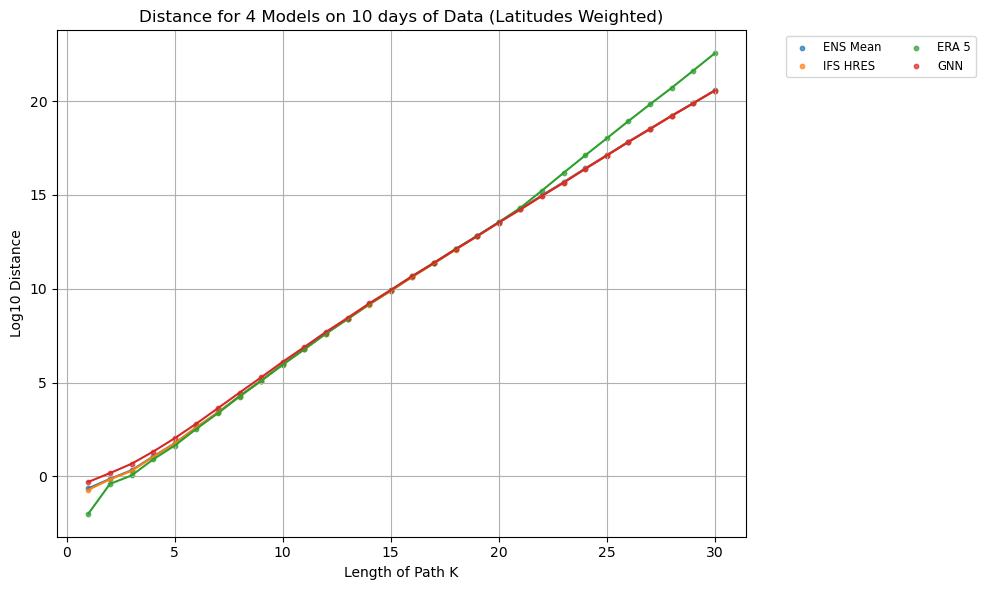

In [276]:
modellist = [distancefull2,distancefull3,distancefull4,distancefull5]
Models = ["ENS Mean", "IFS HRES", "ERA 5", "GNN"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    marker_style = 'o'
    #marker_style = 'o' if model_index < Models.index("Pangu") else '^'
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        np.log10(modellist[model_index][1:]),     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10,                       # Size of the dots
        marker=marker_style  
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, np.log10(modellist[model_index][1:]), alpha=1)

plt.title('Distance for 4 Models on 10 days of Data (Latitudes Weighted)')
plt.xlabel('Length of Path K')
plt.ylabel('Log10 Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

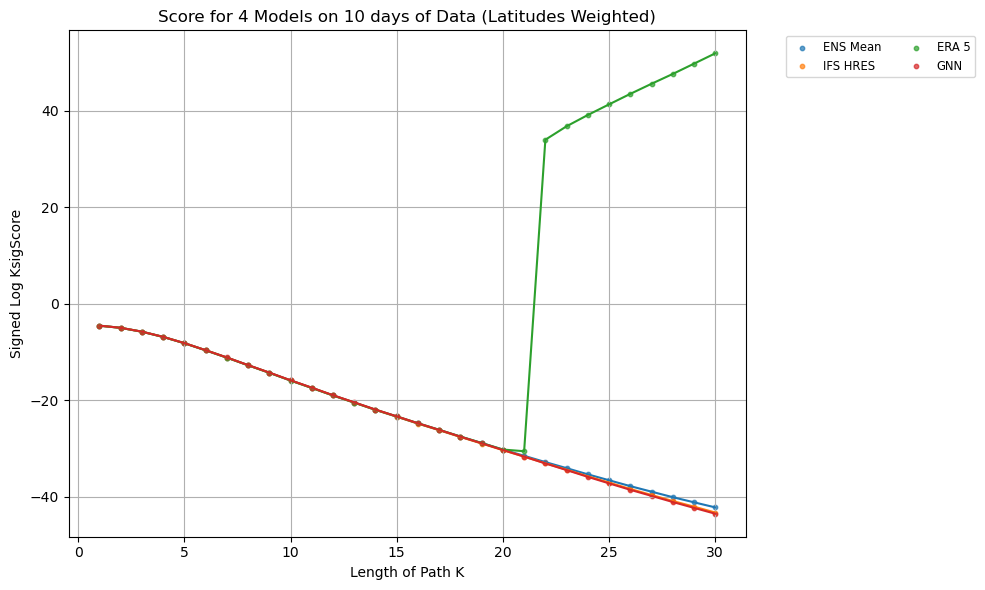

In [300]:
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

modellist = [scorefull2,scorefull3,scorefull4,scorefull5]
Models = ["ENS Mean", "IFS HRES", "ERA 5", "GNN"]
plt.figure(figsize=(10, 6))
# Iterate through each of the 50 models (columns in the array)
for model_index in range(len(Models)):
    marker_style = 'o'
    #marker_style = 'o' if model_index < Models.index("Pangu") else '^'
    plt.scatter(
        np.arange(modellist[model_index][1:].shape[0])+1,  # Time steps (x-axis)
        signed_log(modellist[model_index][1:]),     # Model predictions (y-axis)
        label=f'{Models[model_index]}',
        alpha=0.7,                # Adjust transparency
        s=10,                       # Size of the dots
        marker=marker_style  
    )
    plt.plot(np.arange(modellist[model_index][1:].shape[0])+1, signed_log(modellist[model_index][1:]), alpha=1)

plt.title('Score for 4 Models on 10 days of Data (Latitudes Weighted)')
plt.xlabel('Length of Path K')
plt.ylabel('Signed Log KsigScore')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()
    
    

In [42]:
def pkscaleobs(observations,k,long,lat):
      j = long
      l= lat 

      static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
      dyadic_order = 2
      signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
      time = observations.shape[0]/2
      #print(time) #All forecasts on same time frame
      shiftedtime = math.floor(time- 0.5*k)

      vals = 0

      grid = np.zeros((shiftedtime))

      for i in range(shiftedtime): #20
            fors = observations[2*i:2*i+k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            
            #K_XX - 2* K_Xy
            #signature_kernel.compute_scoring_rule

            grid[i] = K_Xy.item()
      
      vals = sum(grid/shiftedtime)

      return(vals)


def pkscalefors(forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(forecasts.shape[1])

        
        for f in range(forecasts.shape[1]):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[i,f,0:k+1,j,l]
                obs = forecasts[i,f,0:k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                #K_XX - 2* K_Xy
                #signature_kernel.compute_scoring_rule

                grid[i] = K_Xy.item()
            
            vals[f] = sum(grid/shiftedtime)

        return(vals)

def pkscaleall50(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(forecasts.shape[1])

        for f in range(forecasts.shape[1]):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[i,f,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                #K_XX - 2* K_Xy
                #signature_kernel.compute_scoring_rule

                grid[i] = K_Xy.item()
            
            vals[f] = sum(grid/shiftedtime)

        return(vals)